# Using Revenue Data to Estimate Foundation Giving

Non-profits are required to provide an account of their activities to the IRS each year by filing form 990. Charitable foundations, which are a specific type of non-profits, file form 990-PF. The IRS makes available online extracts of these tax forms filed by non-profits each year. 

Charitable foundations are required to distribute a certain amount of their assets each year. This amount, known as the "distributable amount," is the foundation's "minimum investment return with certain adjustments" as determined during the filing process. For this project, I am interested in seeing which factors determine how much above or below the required distribution a a foundation actually gives.

I obtained the data extract of form 990-PF for 2014, which contains summaries of tax returns filed up through fiscal year 2012. The original dataframe has 101,381 samples and 187 columns, which is far too many features to deal with for this project. To narrow things down, I picked one specific area to focus on: foundation revenue. **What effect do different sources of revenue have on how much foundations distribute in charitable giving?**

In [4]:
import pandas as pd
import numpy as np

from sklearn import metrics
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, ElasticNet
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO

# visualization stuff
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


In [5]:
pd.set_option('display.max_columns', None) #force display of all the feature columns
np.set_printoptions(precision=3, suppress=True) #print full numbers, 3 dec points, instead of scientific notation

In [6]:
IRS14Data = pd.read_csv("data/py14_990pf.dat", sep=" ")

In [7]:
IRS14Data.shape

#original dataframe shape is (101381, 178)

(101381, 178)

In [8]:
IRS14Data.describe()

#IRS14Data.dtypes

,EIN,TAX_PRD,EOSTATUS,TAX_YR,SUBCD,FAIRMRKTVALAMT,GRSCONTRGIFTS,INTRSTRVNUE,DIVIDNDSAMT,GRSRENTS,GRSSLSPRAMT,COSTSOLD,GRSPROFITBUS,OTHERINCAMT,TOTRCPTPERBKS,COMPOFFICERS,PENSPLEMPLBENF,LEGALFEESAMT,ACCOUNTINGFEES,INTERESTAMT,DEPRECIATIONAMT,OCCUPANCYAMT,TRAVLCONFMTNGS,PRINTINGPUBL,TOPRADMNEXPNSA,CONTRPDPBKS,TOTEXPNSPBKS,EXCESSRCPTS,TOTRCPTNETINC,TOPRADMNEXPNSB,TOTEXPNSNETINC,NETINVSTINC,TRCPTADJNETINC,TOTEXPNSADJNET,ADJNETINC,TOPRADMNEXPNSD,TOTEXPNSEXEMPT,OTHRCASHAMT,INVSTGOVTOBLIG,INVSTCORPSTK,INVSTCORPBND,TOTINVSTSEC,MRTGLOANS,OTHRINVSTEND,OTHRASSETSEOY,TOTASSETSEND,MRTGNOTESPAY,OTHRLIABLTSEOY,TOTLIABEND,TFUNDNWORTH,FAIRMRKTVALEOY,TOTEXCAPGNLS,TOTEXCAPGN,TOTEXCAPLS,INVSTEXCISETX,SECT511TX,SUBTITLEATX,TOTAXPYR,ESTTAXCR,TXWITHLDSRC,TXPAIDF2758,ERRONBKUPWTHLD,ESTPNLTY,TAXDUE,OVERPAY,CRELAMT,TFAIRMRKTUNUSE,VALNCHARITASSETS,CMPMININVSTRET,DISTRIBAMT,UNDISTRIBINCYR,ADJNETINCCOLA,ADJNETINCCOLB,ADJNETINCCOLC,ADJNETINCCOLD,ADJNETINCTOT,QLFYDISTRIBA,QLFYDISTRIBB,QLFYDISTRIBC,QLFYDISTRIBD,QLFYDISTRIBTOT,VALASSETSCOLA,VALASSETSCOLB,VALASSETSCOLC,VALASSETSCOLD,VALASSETSTOT,QLFYASSETA,QLFYASSETB,QLFYASSETC,QLFYASSETD,QLFYASSETTOT,ENDWMNTSCOLA,ENDWMNTSCOLB,ENDWMNTSCOLC,ENDWMNTSCOLD,ENDWMNTSTOT,TOTSUPRTCOLA,TOTSUPRTCOLB,TOTSUPRTCOLC,TOTSUPRTCOLD,TOTSUPRTTOT,PUBSUPRTCOLA,PUBSUPRTCOLB,PUBSUPRTCOLC,PUBSUPRTCOLD,PUBSUPRTTOT,GRSINVSTINCA,GRSINVSTINCB,GRSINVSTINCC,GRSINVSTINCD,GRSINVSTINCTOT,GRNTAPPRVFUT,PROGSRVCACOLD,PROGSRVCACOLE,PROGSRVCBCOLD,PROGSRVCBCOLE,PROGSRVCCCOLD,PROGSRVCCCOLE,PROGSRVCDCOLD,PROGSRVCDCOLE,PROGSRVCECOLD,PROGSRVCECOLE,PROGSRVCFCOLD,PROGSRVCFCOLE,PROGSRVCGCOLD,PROGSRVCGCOLE,MEMBERSHPDUESD,MEMBERSHPDUESE,INTONSVNGSD,INTONSVNGSE,DVDNDSINTD,DVDNDSINTE
count,1.013810e+05,101381.000000,101381.000000,101381.000000,101381.000000,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013800e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,101381.000000,101381.000000,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,101381.000000,101381.000000,101381.000000,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,101381.000000,1.013810e+05,1.013810e+05,101381.000000,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05,1.013810e+05
mean,4.026936e+08,201316.938884,1.674120,2012.815468,8.319932,8.615635e+06,5.402371e+05,7.798977e+03,1.237013e+05,9.931978e+03,2.859644e+06,2.210815e+03,1.771892e+03,5.977559e+04,1.075685e+06,1.400659e+04,6.728422e+03,2.308283e+03,3.000788e+03,3.147178e+03,6.190886e+03,4.418924e+03,3.986218e+03,5.683157e+02,1.588260e+05,5.726771e+05,7.315175e+05,3.441673e+05,5.220368e+05,4.601780e+04,4.614119e+04,4.769080e+05,3.497403e+04,1.453391e+04,2.248329e+04,8.536866e+04,6.117566e+05,9.690554e+04,2.328441e+05,2.568175e+06,3.726696e+05,3.173689e+06,1.081612e+04,3.337170e+06,2.980368e+05,7.677

In [9]:
#set EIN as the index
IRS14Data.set_index(["EIN"], inplace=True)

The amounts distributed by the foundations (CONTRPDPBKS) in this data set range from 4,108,470,000 (EIN 911663695, the Bill & Melinda Gates Foundation) to 1,404,627 (EIN 597033503, the Wayne M. Densch Charitable Trust). Here is some other information about distributions made:

(array([ 101367.,      11.,       1.,       0.,       0.,       0.,
              0.,       0.,       1.,       1.]),
 array([ -1.405e+06,   4.096e+08,   8.206e+08,   1.232e+09,   1.643e+09,
          2.054e+09,   2.465e+09,   2.876e+09,   3.286e+09,   3.697e+09,
          4.108e+09]),
 <a list of 10 Patch objects>)

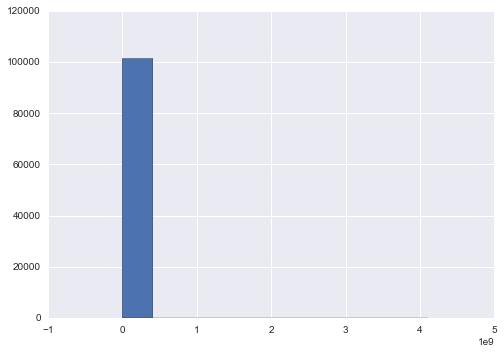

In [7]:
#stats about CONTRPDPBKS (disbursements made)
IRS14Data.CONTRPDPBKS.describe()

sns.plt.hist(IRS14Data.CONTRPDPBKS)


In [10]:
IRS14Data.CONTRPDPBKS.nlargest(100)

EIN
911663695    4108470000
562618866    3392343410
986038021     998473298
223622487     811433684
261215559     783366952
311520982     711632110
460500266     690886838
10575520      686800564
476032365     673777153
261437283     668050404
200031992     625427284
131684331     539139977
431614543     485359572
262502555     452981816
226029397     361065670
263753801     355072530
133441466     311719212
366030614     300000000
137184401     294181939
942278431     288839379
350868122     277485893
943397785     265757322
131879954     233258046
941655673     228220452
237093598     218601920
133794889     209529195
205602483     204007709
954686318     199260813
521690493     197585456
411367441     186775875
                ...    
263241764      80519024
133781879      79704150
43236375       78603357
900747216      78051333
941236937      77952786
650464177      77363977
203759208      77012291
986001597      75452012
263922995      75397333
746036466      74487624
133735187   

In [12]:
IRS14Data.CONTRPDPBKS.nsmallest(10)

EIN
597033503   -1404627
136084636     -93663
222790422     -25450
136181425     -23450
208913138      -6500
237927519      -5000
460498125      -3000
330301860      -2500
330973055      -1190
464881149      -1000
Name: CONTRPDPBKS, dtype: int64

In [13]:
print "Mean of CONTRPDPBKS:", IRS14Data.CONTRPDPBKS.mean()
print "Median of CONTRPDPBKS:", IRS14Data.CONTRPDPBKS.median()
print "Max of CONTRPDPBKS:", IRS14Data.CONTRPDPBKS.max()
print "Min of CONTRPDPBKS:",  IRS14Data.CONTRPDPBKS.min()

Mean of CONTRPDPBKS: 572677.081593
Median of CONTRPDPBKS: 29000.0
Max of CONTRPDPBKS: 4108470000
Min of CONTRPDPBKS: -1404627


We are also interested in knowing more about the required distrbution feature (DISTRIBAMT):

(array([ 101369.,       8.,       2.,       1.,       0.,       0.,
              0.,       0.,       0.,       1.]),
 array([ -1.148e+06,   1.889e+08,   3.789e+08,   5.689e+08,   7.590e+08,
          9.490e+08,   1.139e+09,   1.329e+09,   1.519e+09,   1.709e+09,
          1.899e+09]),
 <a list of 10 Patch objects>)

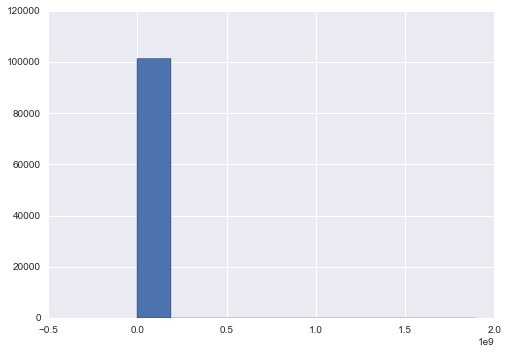

In [8]:
#stats about DISTRIBAMT (distribution required)
IRS14Data.DISTRIBAMT.describe()

sns.plt.hist(IRS14Data.DISTRIBAMT)

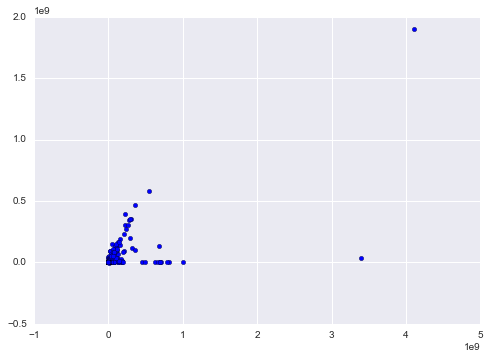

In [9]:
#Let's look at a scatterplot of DISTRIBAMT and CONTRPDPBKS together:

plt.scatter(IRS14Data.CONTRPDPBKS, IRS14Data.DISTRIBAMT)

What we really want to look at, however, is how much above or below the required distribution is actually given by the foundation. So we need to create a new column calculating the difference between the required distribution (DISTRIBAMT) and the actual amount distributed:

(array([ 101365.,       5.,       8.,       1.,       0.,       0.,
              1.,       0.,       0.,       1.]),
 array([ -1.678e+08,   1.849e+08,   5.376e+08,   8.903e+08,   1.243e+09,
          1.596e+09,   1.948e+09,   2.301e+09,   2.654e+09,   3.007e+09,
          3.359e+09]),
 <a list of 10 Patch objects>)

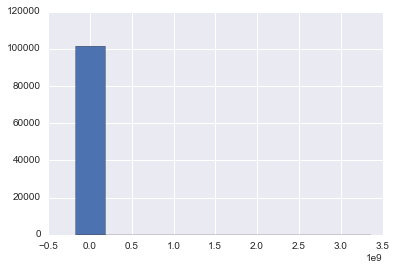

In [11]:
#create column showing the difference between actual distribution and required distribution
IRS14Data["DIST_DELTA"] = IRS14Data["CONTRPDPBKS"] - IRS14Data["DISTRIBAMT"]  

# #DIST_DELTA will be positive if actual dist is more than required; negative is actual dist is less than required

IRS14Data.DIST_DELTA.describe()  #this column is now the last column in the dataframe

#generate histogram of DIST_DELTA
sns.plt.hist(IRS14Data["DIST_DELTA"])



More cleanup!

In [12]:
#remove samples we don't need 

#remove benevolent life insurance associations (SUBCD = 92) so that we're only left with foundations.
IRS14Data = IRS14Data[IRS14Data.SUBCD == 3]

print IRS14Data.SUBCD.value_counts()

#remove super late filed returns for years before 2011. only left with years 2012 and 2012 now.
IRS14Data = IRS14Data[IRS14Data.TAX_YR >= 2012]
print IRS14Data.TAX_YR.value_counts()

3    95321
Name: SUBCD, dtype: int64
2013    80054
2012    14075
Name: TAX_YR, dtype: int64


We can now remove all of the features that don't have anything to do with revenue. The features that we do want to keep are:

* GRSCONTRGIFTS: Contributions received
* INTRSTRVNUE: Interest revenue
* DIVIDNDSAMT: Dividends
* GRSRENTS: Gross rents
* GRSSLSPRAMT: Gross sales price for assets 
* GRSPROFITBUS: Gross profit on sales
* OTHERINCAMT: Other income

Plus DIST_DELTA.

In [13]:
IRS14Data.columns.tolist()[:]

columns = ["GRSCONTRGIFTS", "INTRSTRVNUE", "DIVIDNDSAMT", "GRSRENTS", 
           "GRSSLSPRAMT", "GRSPROFITBUS", "OTHERINCAMT", "DIST_DELTA"]

IRS14Data_clean = IRS14Data[columns]

IRS14Data_clean.describe()



,GRSCONTRGIFTS,INTRSTRVNUE,DIVIDNDSAMT,GRSRENTS,GRSSLSPRAMT,GRSPROFITBUS,OTHERINCAMT,DIST_DELTA
count,9.412900e+04,9.412900e+04,9.412900e+04,9.412900e+04,9.412900e+04,9.412900e+04,9.412900e+04,9.412900e+04
mean,5.787413e+05,8.287641e+03,1.307710e+05,1.052442e+04,3.039458e+06,1.888088e+03,6.352352e+04,2.759471e+05
std,1.814840e+07,2.582936e+05,3.831934e+06,5.988023e+05,2.133368e+08,2.450870e+05,2.141870e+06,1.536804e+07
min,-6.250000e+02,-8.847600e+04,-6.037270e+05,-5.238400e+05,-9.878280e+05,-2.126845e+06,-1.152633e+07,-1.677932e+08
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.077000e+03
50%,0.000000e+00,0.000000e+00,6.471000e+03,0.000000e+00,3.317900e+04,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.048200e+04,3.800000e+01,3.555700e+04,0.000000e+00,3.858710e+05,0.000000e+00,0.000000e+00,2.121400e+04
max,4.115412e+09,4.967970e+07,8.174055e+08,1.572106e+08,6.068395e+10,5.848663e+07,4.086195e+08,3.359349e+09


In [14]:
IRS14Data_clean.shape

#new dataframe shape is 94129 by 8

(94129, 8)

9412.9

In [22]:
#export this as a CSV and save for easier use later.
IRS14Data.to_csv("IRS14Data_clean.csv", sep="\t")

Now that the data is cleaned up and more manageable, we can take another look. 

The distribution delta has a huge range. What does it look like if we remove some of the samples?

In [31]:
#IRS14Data[IRS14Data.DIST_DELTA == 0].count()  #9833 samples where required distribution = actual distribution

#IRS14Data[IRS14Data.DIST_DELTA < 0].count()  #37971 samples where required distribution > actual distribution (D_D negative)

#IRS14Data[IRS14Data.DIST_DELTA > 0].count()  #46325 samples where required distribution < actual distribution (D_D positive)

(94100, 8)


(array([     1.,      0.,      2.,      5.,      9.,     42.,  93912.,
            93.,     24.,     12.]),
 array([ -1.678e+08,  -1.415e+08,  -1.152e+08,  -8.886e+07,  -6.254e+07,
         -3.623e+07,  -9.919e+06,   1.639e+07,   4.271e+07,   6.902e+07,
          9.533e+07]),
 <a list of 10 Patch objects>)

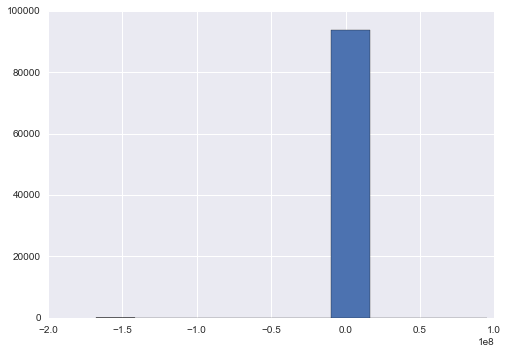

In [14]:
#Only those with less than $100M in DIST_DELTA

IRS14Data_Less_100M_Club = IRS14Data_clean[IRS14Data_clean.DIST_DELTA < 100000000]

print IRS14Data_Less_100M_Club.shape

sns.plt.hist(IRS14Data_Less_100M_Club.DIST_DELTA)

(array([ 46312.,      5.,      6.,      0.,      0.,      0.,      1.,
             0.,      0.,      1.]),
 array([  1.000e+00,   3.359e+08,   6.719e+08,   1.008e+09,   1.344e+09,
          1.680e+09,   2.016e+09,   2.352e+09,   2.687e+09,   3.023e+09,
          3.359e+09]),
 <a list of 10 Patch objects>)

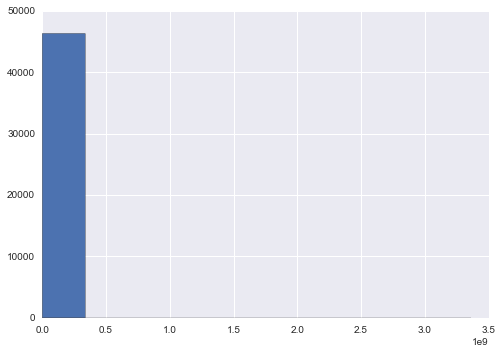

In [20]:
#only those with more than $0 in DIST_DELTA

IRS14Data_Zero_Club = IRS14Data_clean[IRS14Data_clean.DIST_DELTA > 0]
sns.plt.hist(IRS14Data_Zero_Club.DIST_DELTA)

(82716, 8)


(array([     1.,      0.,      0.,      1.,      2.,      3.,      2.,
             8.,     17.,  82682.]),
 array([ -1.678e+08,  -1.510e+08,  -1.342e+08,  -1.174e+08,  -1.006e+08,
         -8.385e+07,  -6.706e+07,  -5.027e+07,  -3.348e+07,  -1.669e+07,
          1.000e+05]),
 <a list of 10 Patch objects>)

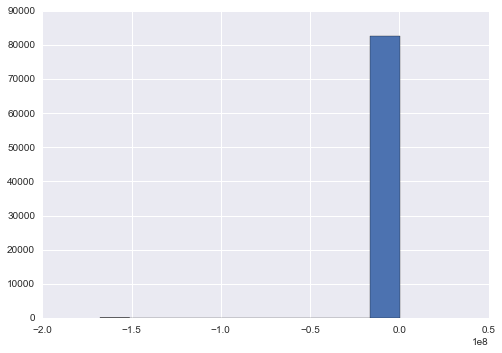

In [18]:
#only those with less than $100k in DIST_DELTA
IRS14Data_Less_100K_Club = IRS14Data_clean[IRS14Data_clean.DIST_DELTA < 100000]

print IRS14Data_Less_100K_Club.shape
sns.plt.hist(IRS14Data_Less_100K_Club.DIST_DELTA)

#IRS14Data_Less_100K_Club.describe()
#looks like most foundations gave between $0-$10k more than they were required to

(34912, 8)


(array([ 16843.,   5490.,   3329.,   2400.,   1835.,   1435.,   1123.,
           944.,    798.,    715.]),
 array([     1. ,  10000.6,  20000.2,  29999.8,  39999.4,  49999. ,
         59998.6,  69998.2,  79997.8,  89997.4,  99997. ]),
 <a list of 10 Patch objects>)

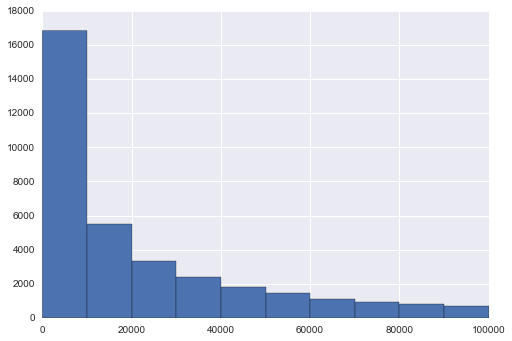

In [25]:
#only those with more than $0 but less than $100k in DIST_DELTA

IRS14Data_Zero_100K_Club = IRS14Data_Zero_Club[IRS14Data_Zero_Club.DIST_DELTA < 100000]

print IRS14Data_Zero_100K_Club.shape
sns.plt.hist(IRS14Data_Zero_100K_Club.DIST_DELTA)


(91823, 8)


(array([     1.,      0.,      0.,      1.,      2.,      4.,      1.,
             8.,     21.,  91785.]),
 array([ -1.678e+08,  -1.509e+08,  -1.340e+08,  -1.172e+08,  -1.003e+08,
         -8.340e+07,  -6.652e+07,  -4.964e+07,  -3.276e+07,  -1.588e+07,
          9.996e+05]),
 <a list of 10 Patch objects>)

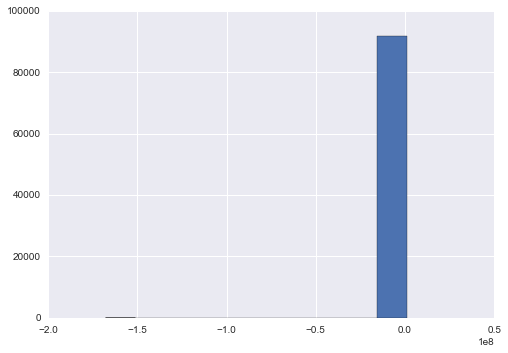

In [19]:
#only those with less than $1M in DIST_DELTA
IRS14Data_Less_1M_Club = IRS14Data_clean[IRS14Data_clean.DIST_DELTA < 1000000]

print IRS14Data_Less_1M_Club.shape
sns.plt.hist(IRS14Data_Less_1M_Club.DIST_DELTA)

(9091, 8)


(array([ 3731.,  1786.,  1024.,   698.,   520.,   372.,   310.,   258.,
          195.,   197.]),
 array([ 100004. ,  189961.5,  279919. ,  369876.5,  459834. ,  549791.5,
         639749. ,  729706.5,  819664. ,  909621.5,  999579. ]),
 <a list of 10 Patch objects>)

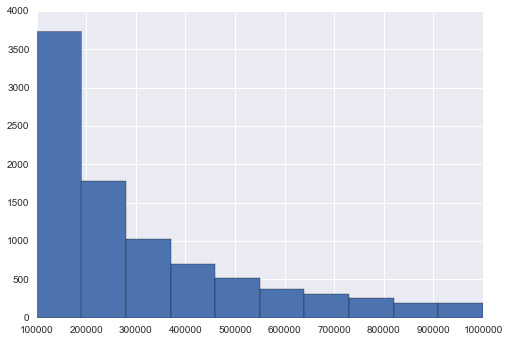

In [29]:
#only those with more than $100k but less than $1M in DIST_DELTA
IRS14Data_100K_1M_Club = IRS14Data_Less_1M_Club[IRS14Data_Less_1M_Club.DIST_DELTA > 100000]

print IRS14Data_100K_1M_Club.shape
sns.plt.hist(IRS14Data_100K_1M_Club.DIST_DELTA)

It looks like most of the samples gave in the $10k range above what they were required to give. The outliers at either end skew the histogram of the entire dataset.

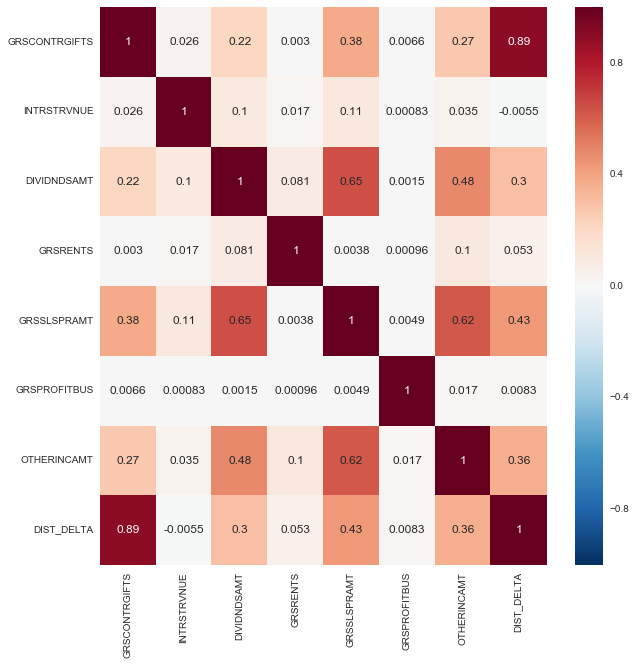

In [32]:
#run corr and generate heatmap on the entire dataframe - anything interesting??

Data_Corr = IRS14Data_clean.corr()

big = (10,10)
fig, ax = plt.subplots(figsize=big)

fig_heatmap = sns.heatmap(Data_Corr, annot=True, fmt =".2g")

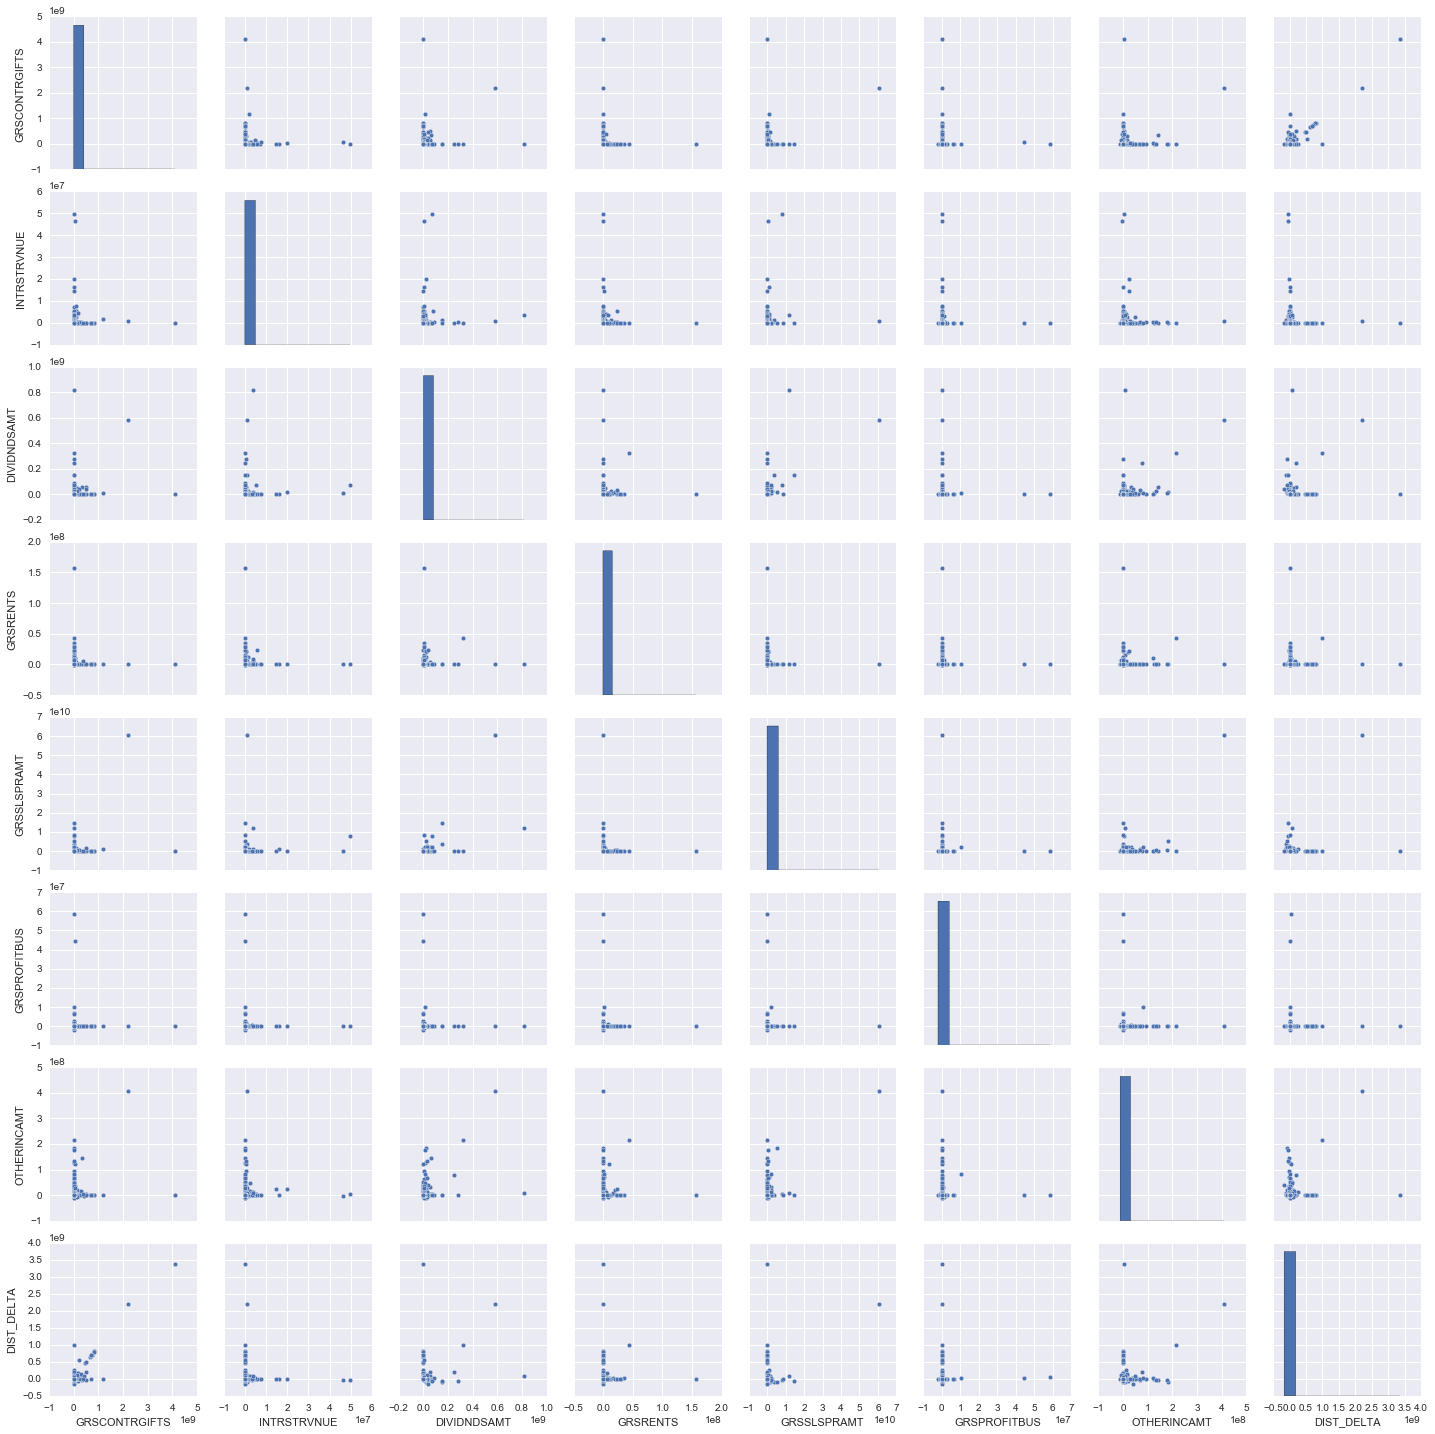

In [33]:
sns.pairplot(IRS14Data_clean)

It looks like there may be two or three different clusters in the data. Let's use KMeans to try to tease these out.

Then we will try a couple different models to see which features have the strongest effects.

In [15]:
#first, need to identify our features (X) and our target (y)
IRS14_features = IRS14Data_clean.columns.tolist()[:-1] #select all features except for DIST_DELTA
X = IRS14Data_clean[IRS14_features] #X is all our features except DIST_DELTA
y = IRS14Data_clean.DIST_DELTA #y is what we want to predict (DIST_DELTA)

print IRS14Data_clean.columns.tolist()[:-1]

['GRSCONTRGIFTS', 'INTRSTRVNUE', 'DIVIDNDSAMT', 'GRSRENTS', 'GRSSLSPRAMT', 'GRSPROFITBUS', 'OTHERINCAMT']


In [40]:
#let's try a linear regression model. this is easy to understand so it's a good place to start.

lr = LinearRegression()

lr.fit(X,y)

coeffs = lr.coef_
intercept =  lr.intercept_

print intercept
zip(X, lr.coef_)

-205374.257508


[('GRSCONTRGIFTS', 0.71659935055324531),
 ('INTRSTRVNUE', -2.3385707648391199),
 ('DIVIDNDSAMT', 0.23367771063337822),
 ('GRSRENTS', 0.95043638776144168),
 ('GRSSLSPRAMT', 0.0017870205808940831),
 ('GRSPROFITBUS', 0.064901198667952825),
 ('OTHERINCAMT', 0.62751202233215575)]

An intercept of -205374 means that without any other interfering factors, the amount that a foundation distributes will be $200k less than the amount they are required to distribute.
Of the features, interest revenue appears to have the biggest effect (-2.3), followed by gross rents (.95).

In [41]:
# what's the predictive value of the linear model?

y_predict = lr.predict(X)
print "R2 score:", metrics.r2_score(y, y_predict)
print "MAE:", metrics.mean_absolute_error(y, y_predict) #average error of 500k = not a good model!!
print "MSE:", metrics.mean_squared_error(y, y_predict)
print "RMSE:", np.sqrt(metrics.mean_squared_error(y, y_predict))

R2 score: 0.815848831683
MAE: 593686.426691
MSE: 4.34917571898e+13
RMSE: 6594828.0637


In [42]:
#let's try a random forest model

###re do this with cv

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)

print "Random Forest MSE:",mean_squared_error(y_test,y_predict_rf)
print "Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_predict_rf))

Random Forest MSE: 3.66175069718e+13
Random Forest RMSE: 6051240.1185


In [16]:
#let's try a random forest model

###re do this with cv

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

rf = RandomForestRegressor(n_estimators=20)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)

print "Random Forest MSE:",mean_squared_error(y_test,y_predict_rf)
print "Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_predict_rf))

Random Forest MSE: 1.38553043106e+13
Random Forest RMSE: 3722271.39132


In [ ]:
#i could not get this to run! possibly because my laptop sux.
#try some different estimator values
estimator_range = range(20, 100, 20)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, bootstrap=True, oob_score=True, random_state=1)
    rfreg.fit(X_train,y_train)
    preds = rfreg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    RMSE_scores.append(rmse)

In [ ]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

In [43]:
#now that we have done some preliminary exploring, time to scale the data to make a more advanced analysis possible

scaler = StandardScaler() 
IRS14_Data_scaled = scaler.fit_transform(IRS14Data_clean[IRS14_features])
IRS14_Data_scaled = pd.DataFrame(IRS14_Data_scaled,columns=IRS14_features)

# scaler.fit(X) 
# X_scaled = scaler.transform(X)

# print X_scaled

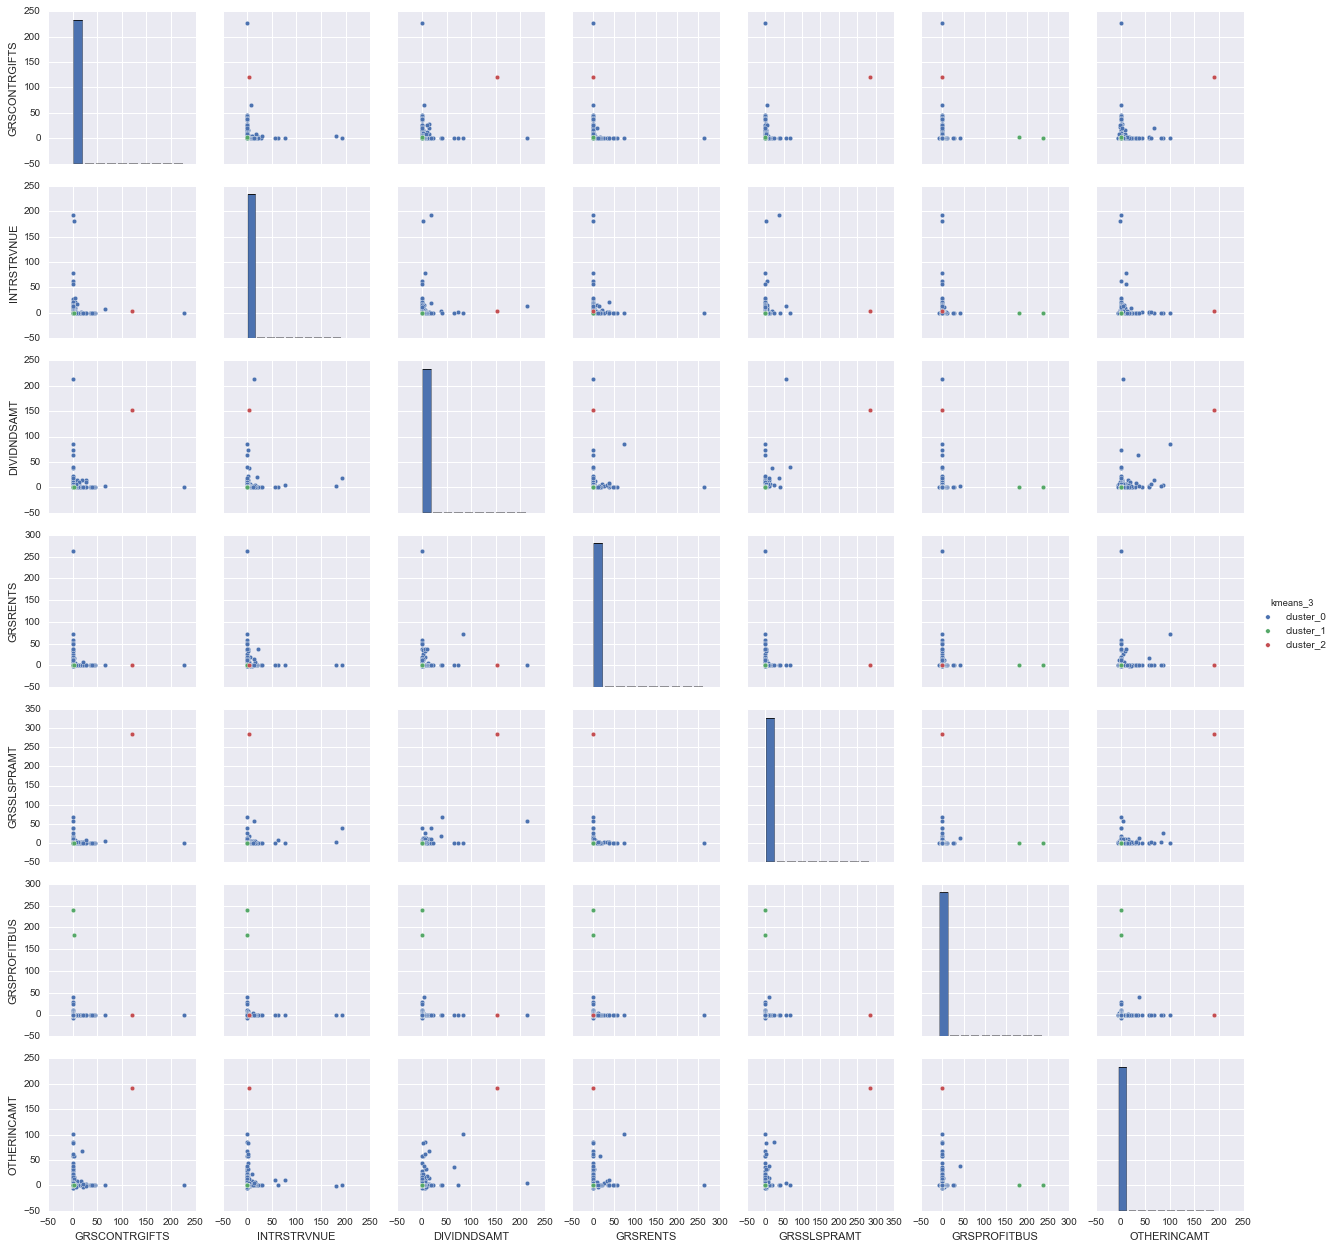

In [44]:
#using scaled data to try to identify clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3,random_state=1234)
kmeans.fit(IRS14_Data_scaled[IRS14_features])

IRS14_Data_scaled["kmeans_3"] = ["cluster_"+str(label) for label in kmeans.labels_]
sns.pairplot(IRS14_Data_scaled,hue="kmeans_3")


print "Silhouette score when k=3 and data scaled:",silhouette_score(IRS14_Data_scaled, km.labels_)

C:\Users\Laura\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


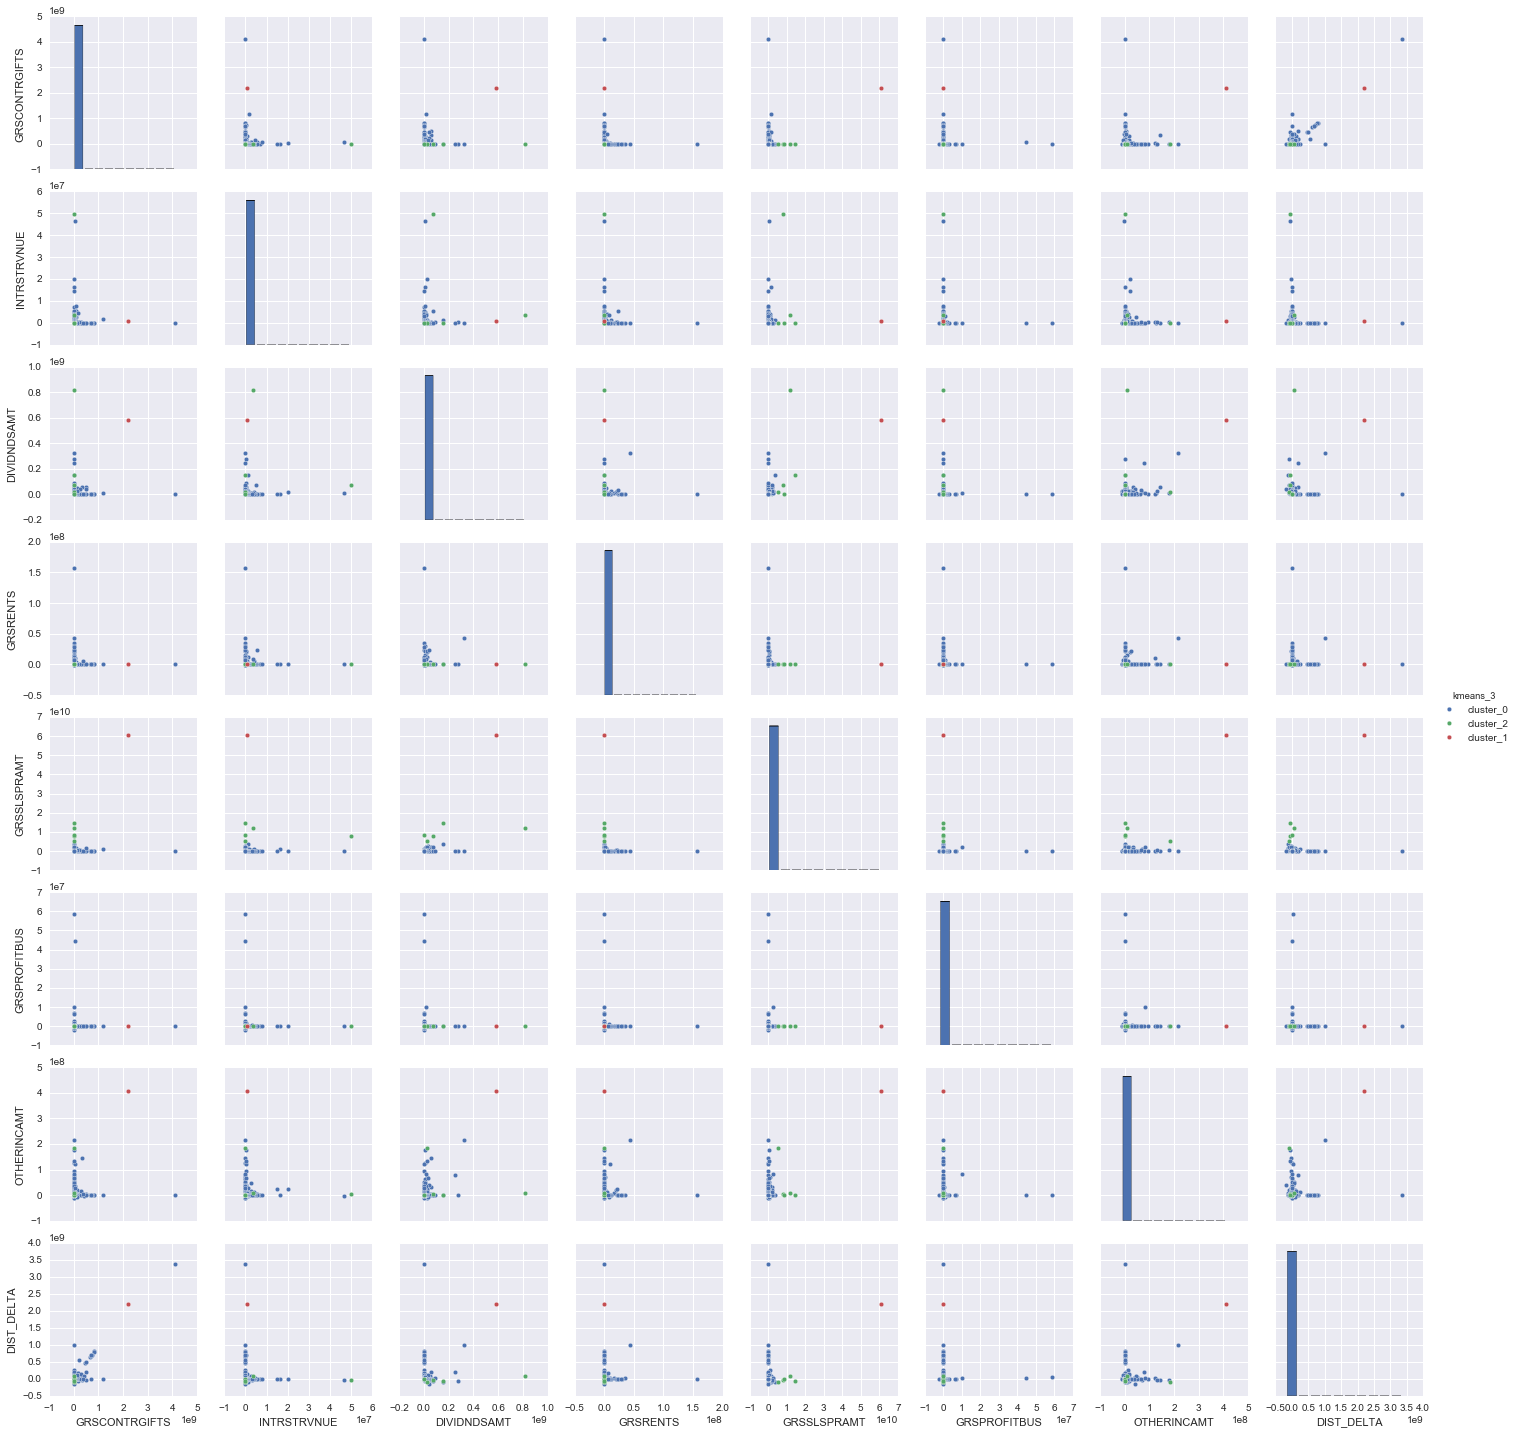

In [39]:
#using unscaled data

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3,random_state=1234)
kmeans.fit(IRS14Data_clean[IRS14_features])

IRS14Data_clean["kmeans_3"] = ["cluster_"+str(label) for label in kmeans.labels_]
sns.pairplot(IRS14Data_clean,hue="kmeans_3")


print "Silhouette score when k=3 and data is not scaled:",silhouette_score(IRS14Data_clean, km.labels_)

not much of a difference...